In [1]:
# Dataset configuration (resize images, load images, split dataset into train, validation, test)

import os
import cv2
import numpy as np

img_size = (150, 150)

train_dir = '../../dataset/train'
validation_dir = '../../dataset/val'
test_dir = '../../dataset/test'

def resize_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            img_path = os.path.join(label_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)

    if (directory == train_dir):
        images = images[:3500]
        labels = labels[:3500]

    return np.array(images), np.array(labels)


X_train, y_train = resize_images_from_directory(train_dir)
X_validation, y_validation = resize_images_from_directory(validation_dir)
X_test, y_test = resize_images_from_directory(test_dir)

X_train = X_train.reshape(X_train.shape[0], -1)
X_validation = X_validation.reshape(X_validation.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [2]:
# Generate synthetic samples using SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [3]:
# Use pipeline to scale the data and train the model

from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model = StackingClassifier([('svc', SVC(C=0.01, kernel='linear', gamma='scale')),
                            ('knn', KNeighborsClassifier(n_neighbors=3, algorithm='auto'))], 
                            KNeighborsClassifier())

pipeline = make_pipeline(StandardScaler(), model)

params = {
    # 'stackingclassifier__svc__C': [0.1, 1, 10],
    # 'stackingclassifier__svc__kernel': ['linear', 'rbf', 'poly'],
    # 'stackingclassifier__svc__gamma': ['scale', 'auto'],
    # 'stackingclassifier__knn__n_neighbors': [1, 2, 3, 4, 5],
    # 'stackingclassifier__knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    # 'stackingclassifier__knn__leaf_size': [20, 30, 40],
}

grid = GridSearchCV(pipeline, params, cv=3)
grid.fit(X_train, y_train)
grid.score(X_validation, y_validation)

0.875

0.8012820512820513
Success Rate: 0.8012820512820513
Success Rate for Pneumonia: 0.9564102564102565
Success Rate for Normal: 0.5427350427350427


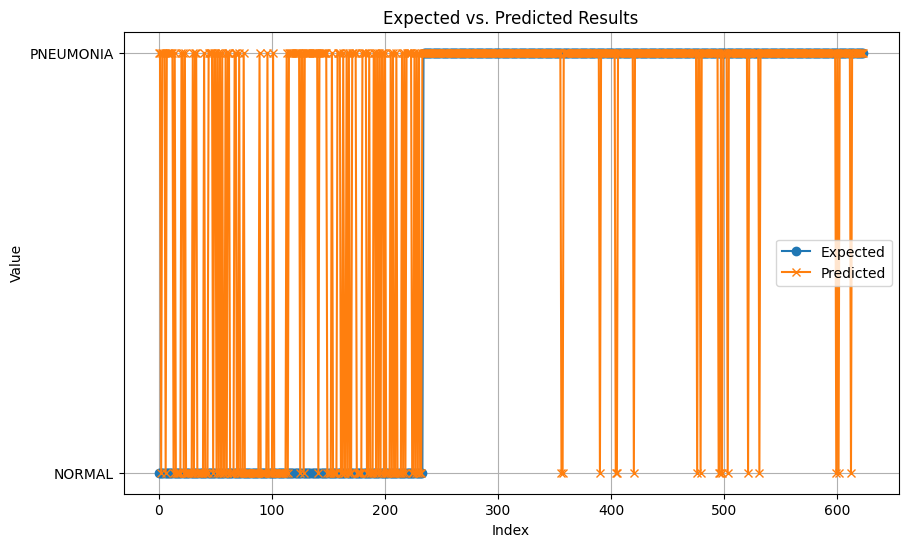

In [4]:
# Evaluate the model

import matplotlib.pyplot as plt

predictions = grid.predict(X_test)
indices = np.arange(len(y_test))

def success_rate() :
    num_correct = sum(y_test == predictions)
    total_predictions = len(y_test)
    return num_correct / total_predictions

def success_rate_per_class(class_name):
    expected = y_test[y_test == class_name]
    predicted = predictions[y_test == class_name]
    num_correct = sum(expected == predicted)
    total_predictions = len(expected)
    return num_correct / total_predictions

print(success_rate())

print("Success Rate:", success_rate())
print("Success Rate for Pneumonia:", success_rate_per_class('PNEUMONIA'))
print("Success Rate for Normal:", success_rate_per_class('NORMAL'))

plt.figure(figsize=(10, 6))
plt.plot(indices, y_test, label='Expected', marker='o')
plt.plot(indices, predictions, label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Expected vs. Predicted Results')
plt.legend()
plt.grid(True)
plt.show()